In [13]:
import torch
import pandas as pd
import json
import transformer_ee.dataloader.string_conv as string_conv
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [14]:
if torch.cuda.is_available():
    mps_device = torch.device("cuda")
else:
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
    else:
        mps_device = torch.device("cpu")

In [15]:
df = pd.read_csv(
    "transformer_ee/data/2022-08-21_rnne_NC_250_fGScatter_20MeV_KE_01e8_max_trackE_cut.csv.xz"
)

with open("transformer_ee/config/input.json", "r") as f:
    input_d = json.load(f)


In [16]:
for particle_feature in input_d["vector"]:
    df[particle_feature] = df[particle_feature].apply(string_conv.string_to_float_list)

In [17]:
class Pandas_NC_Dataset(Dataset):
    def __init__(self, dataframe, config: dict):
        self.df = dataframe
        self.len = len(dataframe)
        self.maxpronglen = config["max_num_prongs"]
        self.vectornames = config["vector"]
        self.scalarnames = config["scalar"]
        self.targetname = config["target"]

        # calculate mean and std for normalization
        self.stat_scalar = []
        for x in self.scalarnames:
            self.stat_scalar.append([df[x].mean(), df[x].std()])
        self.stat_scalar = torch.Tensor(self.stat_scalar).T
        self.stat_scalar = self.stat_scalar[:, None, :]

        self.stat_vector = []
        for x in self.vectornames:
            _tmp = []
            for y in df[x]:
                _tmp.extend(y)
            self.stat_vector.append([np.mean(_tmp), np.std(_tmp)+1E9])
        self.stat_vector = torch.Tensor(self.stat_vector).T
        self.stat_vector = self.stat_vector[:, None, :]
        self.d = {}

    def __getitem__(self, index):
        if index in self.d:
            return self.d[index]

        row = self.df.iloc[index]
        _vectorsize = len(row[self.vectornames[0]])
        _vector = torch.Tensor(row[self.vectornames]).T
        _scalar = torch.Tensor(row[self.scalarnames]).T
        _vector = _vector / self.stat_vector[1]
        _scalar = _scalar / self.stat_scalar[1]

        return_tuple = (
            # pad the vector to maxpronglen with zeros
            F.pad(_vector, (0, 0, 0, self.maxpronglen - _vectorsize), "constant", 0),
            # return the scalar
            _scalar,
            # return src_key_padding_mask
            F.pad(
                torch.zeros(_vectorsize, dtype=torch.bool),
                (0, self.maxpronglen - _vectorsize),
                "constant",
                1,  # pad with True
            ),
            torch.Tensor(row[self.targetname]),
        )
        self.d[index] = return_tuple
        return return_tuple

    def __len__(self):
        return self.len


In [18]:
dataset = Pandas_NC_Dataset(df, input_d)

batch_size_train = 1024
batch_size_valid = 256
batch_size_test = 3000


In [19]:
seed = 0
_indices = np.arange(len(df))
np.random.seed(seed)
np.random.shuffle(_indices)
test_size = 0.2
valid_size = 0.05  # of the train_valid_indicies
train_valid_indicies = _indices[: int(len(_indices) * (1 - test_size))]
train_indicies = train_valid_indicies[
    : int(len(train_valid_indicies) * (1 - valid_size))
]
valid_indicies = train_valid_indicies[
    int(len(train_valid_indicies) * (1 - valid_size)) :
]
test_indicies = _indices[int(len(_indices) * (1 - test_size)) :]


In [20]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indicies)
valid_dataset = Subset(dataset, valid_indicies)
test_dataset = Subset(dataset, test_indicies)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)

validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size_valid,
                                            shuffle=False)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)

In [21]:
from transformer_ee.model.transformerEncoder import Transformer_EE_v1
net=Transformer_EE_v1().to(mps_device)

In [22]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
train_loss_list = [] # list to store training losses after each epoch
valid_loss_list = [] # list to store validation losses after each epoch

epochs = 100
lossfunc = nn.MSELoss()

print_interval = 1

for i in range(epochs):

    net.train()  # begin training

    batch_train_loss = []

    for (batch_idx, batch) in enumerate(trainloader):

        vector_train_batch = batch[0].to(mps_device)
        scalar_train_batch = batch[1].to(mps_device)
        mask_train_batch = batch[2].to(mps_device)
        target_train_batch = batch[3].to(mps_device)

        Netout = net.forward(vector_train_batch, mask_train_batch)
        # This will call the forward function, usually it returns tensors.

        loss = torch.mean(
            torch.abs((Netout - target_train_batch) / target_train_batch)
        )  # regression loss

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        batch_train_loss.append(loss)
        if batch_idx % print_interval == 0:
            # print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))
    train_loss_list.append(torch.mean(torch.Tensor(batch_train_loss)))
    torch.save(net.state_dict(), "transformer_ee/model/transformer_ee_v1.pt")


    net.eval()  # begin validation
    net.cpu()
    batch_valid_loss = []

    for (batch_idx, batch) in enumerate(validloader):
        vector_valid_batch = batch[0]
        scalar_valid_batch = batch[1]
        mask_valid_batch = batch[2]
        target_valid_batch = batch[3]

        Netout = net.forward(vector_valid_batch, mask_valid_batch)
        # This will call the forward function, usually it returns tensors.

        loss = torch.mean(
            torch.abs((Netout - target_valid_batch) / target_valid_batch)
        )
        batch_valid_loss.append(loss)
        if batch_idx % print_interval == 0:
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))
    valid_loss_list.append(torch.mean(torch.Tensor(batch_valid_loss)))
    net.to(mps_device)

    print("Epoch: {}, train_loss: {:0.4f}, valid_loss: {:0.4f}".format(i, train_loss_list[-1], valid_loss_list[-1]))
    if i > 10:
        if valid_loss_list[-1] > valid_loss_list[-2]:
            print("Early stopping")
            break


/var/folders/f_/6c826v810dx25pkgjg_810h00000gn/T/ipykernel_58422/3395705961.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  _scalar = torch.Tensor(row[self.scalarnames]).T
/opt/homebrew/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, batch: 0 Loss: 0.8043
Epoch: 0, batch: 1 Loss: 5.2819
Epoch: 0, batch: 2 Loss: 3.1896
Epoch: 0, batch: 3 Loss: 1.0357
Epoch: 0, batch: 4 Loss: 1.4912
Epoch: 0, batch: 5 Loss: 1.5266
Epoch: 0, batch: 6 Loss: 0.9220
Epoch: 0, batch: 7 Loss: 0.6814
Epoch: 0, batch: 8 Loss: 0.8804
Epoch: 0, batch: 9 Loss: 0.9201
Epoch: 0, batch: 10 Loss: 0.7663
Epoch: 0, batch: 11 Loss: 0.6645
Epoch: 0, batch: 12 Loss: 0.6734
Epoch: 0, batch: 13 Loss: 0.7714
Epoch: 0, batch: 14 Loss: 0.7646
Epoch: 0, batch: 15 Loss: 0.7667
Epoch: 0, batch: 16 Loss: 0.8341
Epoch: 0, batch: 17 Loss: 0.6978
Epoch: 0, batch: 18 Loss: 0.7064
Epoch: 0, batch: 19 Loss: 0.6644
Epoch: 0, batch: 20 Loss: 0.7035
Epoch: 0, batch: 21 Loss: 0.7243
Epoch: 0, batch: 22 Loss: 0.7060
Epoch: 0, batch: 23 Loss: 0.7339
Epoch: 0, batch: 24 Loss: 0.6765
Epoch: 0, batch: 25 Loss: 0.6680
Epoch: 0, batch: 26 Loss: 0.6970
Epoch: 0, batch: 27 Loss: 0.6621
Epoch: 0, batch: 28 Loss: 0.6867
Epoch: 0, batch: 29 Loss: 0.6418
Epoch: 0, batch: 30 

In [12]:
torch.save(net.state_dict(), "transformer_ee/model/transformer_ee_v1.pt")


In [23]:
from transformer_ee.model.transformerEncoder import Transformer_EE_v1

net=Transformer_EE_v1()
net.load_state_dict(torch.load("transformer_ee/model/transformer_ee_v1.pt", map_location=torch.device('cpu')))
net.eval()

Transformer_EE_v1(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(

In [29]:
a=dataset.df

mean resolution:  -0.03956083
std resolution:  0.3671083
rms resolution:  0.36923373


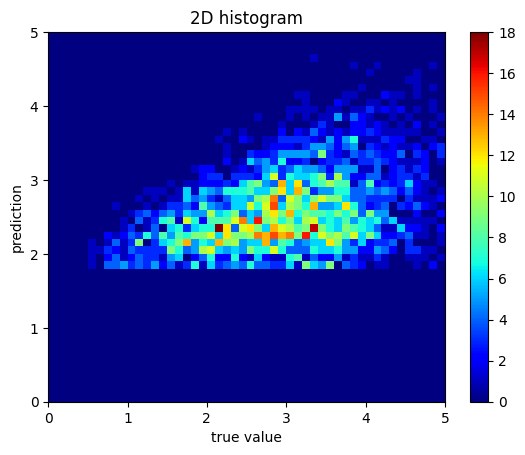

In [27]:
net.eval()
net.to(mps_device)
a, b, c, d=next(iter(testloader))
net.cpu()
e=net.forward(a, c)

from matplotlib import pyplot as plt
trueval=d[:, 0].cpu().detach().numpy()
prediction=e[:, 0].cpu().detach().numpy()
resolution=(prediction-trueval)/trueval
print("mean resolution: ", np.mean(resolution))
print("std resolution: ", np.std(resolution))
print('rms resolution: ', np.sqrt(np.mean(resolution**2)))
plt.title("resolution")
plt.hist(resolution, bins=100)
plt.xlim(-1, 1)
plt.savefig("resolution.png")

plt.scatter(trueval, prediction)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("true value")
plt.ylabel("prediction")
plt.savefig("p2DScatter.png")

net.to(mps_device)
plt.hist2d(trueval, prediction, bins=(50, 50), cmap=plt.cm.jet, range=[[0, 5], [0, 5]])
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("true value")
plt.ylabel("prediction")
plt.title("2D histogram")
plt.colorbar()
plt.savefig("p2DHist.png")

In [ ]:
net.linear.bias

Parameter containing:
tensor([1.4735, 0.5868], device='mps:0', requires_grad=True)

In [ ]:
print(net.linear.weight)

Parameter containing:
tensor([[ 0.0826,  0.2156, -0.2129,  0.2783, -0.1241,  0.0631, -0.0142, -0.2118,
          0.1924, -0.1685,  0.0136,  0.0490],
        [-0.1377,  0.0334, -0.0112, -0.2163, -0.0388,  0.0768,  0.1274,  0.1059,
         -0.0129,  0.1251,  0.1158,  0.1096]], device='mps:0',
       requires_grad=True)


/opt/homebrew/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [ ]:
print(net.linear.bias)

Parameter containing:
tensor([-0.1471,  0.3031], device='mps:0', requires_grad=True)


In [30]:
next(iter(testloader))

[tensor([[[ 1.0000e-09,  1.6386e-07,  3.3696e-07,  ...,  2.3490e-02,
            1.1895e-04,  3.6000e-07],
          [ 0.0000e+00,  2.8420e-08,  3.3730e-07,  ...,  1.2995e-02,
            6.5805e-05,  1.4100e-07],
          [ 0.0000e+00,  9.5375e-09,  3.3680e-07,  ...,  4.9789e-03,
            2.5213e-05,  4.7000e-08],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 0.0000e+00,  4.0088e-08, -1.5719e-07,  ...,  1.0465e-02,
            5.2996e-05,  2.1700e-07],
          [ 0.0000e+00,  1.7114e-08, -1.7816e-07,  ...,  6.8684e-03,
            3.4781e-05,  7.4000e-08],
          [ 0.0000e+00,  1.3607e-08, -1.6186e-07,  ...,  7.0363e-03,
            3.5631e-05,  3.9000e-08],
          ...,
    

In [ ]:
a

tensor([[[ 1.3970e+00,  2.1801e+00,  1.6237e+00,  ...,  4.4725e-01,
           4.4726e-01,  4.0303e-01],
         [-7.1584e-01, -3.1329e-01,  1.6254e+00,  ..., -9.2862e-02,
          -9.2861e-02, -2.4834e-01],
         [-7.1584e-01, -6.6090e-01,  1.6229e+00,  ..., -5.0540e-01,
          -5.0540e-01, -5.2792e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-7.1584e-01, -9.8494e-02, -7.5849e-01,  ..., -2.2304e-01,
          -2.2303e-01, -2.2293e-02],
         [-7.1584e-01, -5.2142e-01, -8.5963e-01,  ..., -4.0816e-01,
          -4.0816e-01, -4.4761e-01],
         [-7.1584e-01, -5.8599e-01, -7.8101e-01,  ..., -3.9952e-01,
          -3.9952e-01, -5.5171e-01],
         ...,
         [ 0.0000e+00,  0

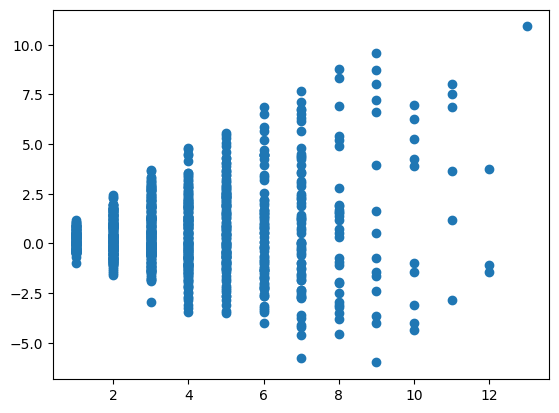

In [ ]:
plt.scatter(np.sum(np.array(a[:, :, 0], dtype=bool), axis=1), prediction)

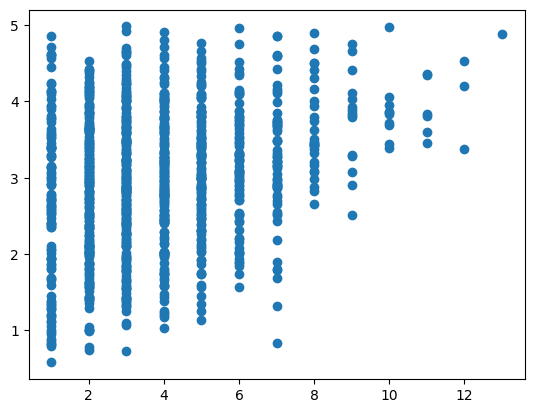

In [ ]:
plt.scatter(np.sum(np.array(a[:, :, 0], dtype=bool), axis=1), trueval)

In [ ]:
a[:, :, 0].shape

torch.Size([1024, 20])

In [ ]:
np.sum(np.array(a[:, :, 0], dtype=bool), axis=1)

array([ 3,  3, 12, ...,  3, 11,  4])

<AxesSubplot: >

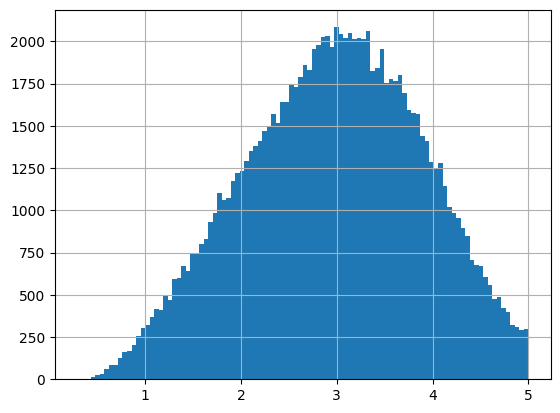

In [ ]:
df['mc.nuE'].hist(bins=100)